In [2]:
import numpy as np
import pandas as pd

df = pd.read_csv("../data/total_data.csv")

In [3]:
df.drop(columns=['Unnamed: 0'], inplace=True)

df.rename(columns={"full_date": "date_time",
                  "pm": "value"}, inplace=True)

In [17]:
import sktime
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn
import datetime
import pandas as pd
import statsmodels
import numpy as np

from functions import holt_winters_imputation_and_expand, plot_imputation_results

In [5]:
df.set_index("date_time", inplace=True)

df.index = pd.to_datetime(df.index)

# Generate the complete range of dates
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

# Reindex the DataFrame to include all dates
df = df.reindex(full_range)

# Set the index name back (optional)
df.index.name = 'date_time'

In [6]:
df = pd.read_csv("../data/imputed_mean.csv")


In [13]:
df

,date_time,value
0,2017-03-22,91.982979
1,2017-03-23,84.649269
2,2017-03-24,126.039535
3,2017-03-25,63.183913
4,2017-03-26,38.572597
...,...,...
1291,2020-10-03,41.795789
1292,2020-10-04,32.194444
1293,2020-10-05,30.645000
1294,2020-10-06,24.271667


In [10]:
heating_season_dates = [
    # start,        end
    ['2016-10-15', '2017-04-10'],
    ['2017-10-15', '2018-04-12'],
    ['2018-10-15', '2019-04-04'],
    ['2019-10-15', '2020-04-20'],
    ['2020-09-28', '2021-04-13'],
    # ['2021-10-02', '2022-04'],
]

Heating Season Value Distribution:
count    571.000000
mean      77.871391
std       42.493211
min       12.709763
25%       46.517272
50%       68.842033
75%       97.769695
max      259.568449
Name: value, dtype: float64

Non-Heating Season Value Distribution:
count    725.000000
mean      22.121176
std        9.450115
min        7.769390
25%       15.547671
50%       20.401168
75%       25.688947
max       71.980782
Name: value, dtype: float64


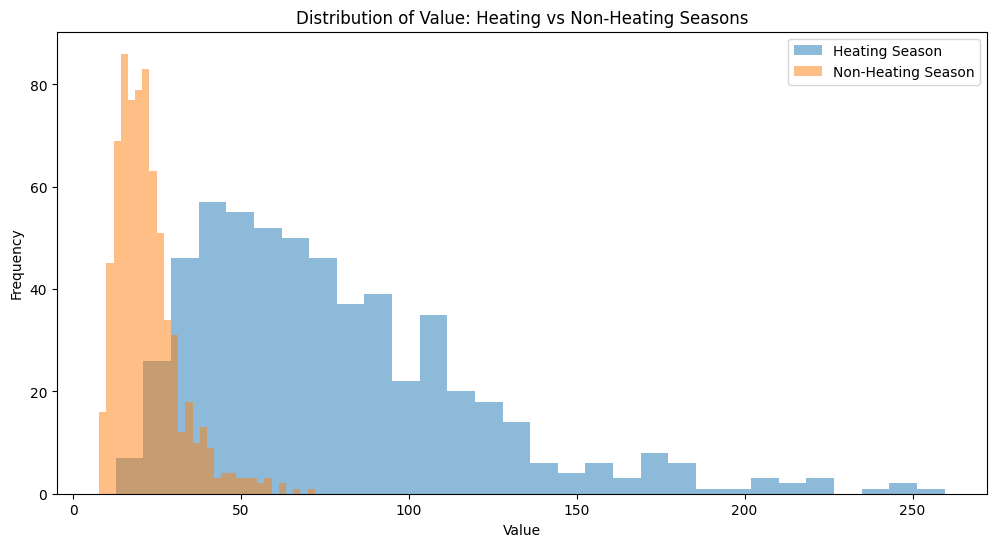

<Figure size 800x600 with 0 Axes>

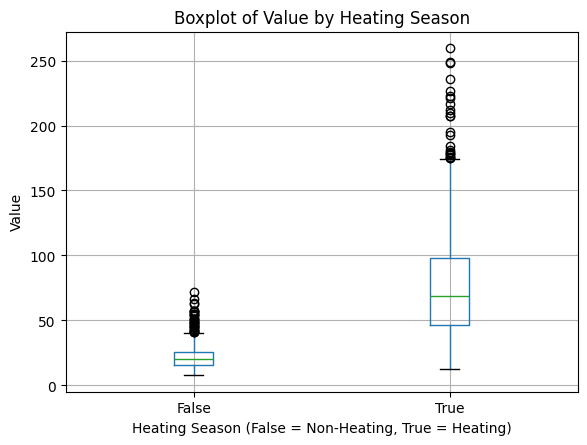

In [18]:
def is_heating(date):
    return any(start <= date <= end for start, end in heating_season_dates)

# Apply the function to create a new column 'heating'
df['heating'] = df['date_time'].apply(is_heating)

# 4. Split the DataFrame into heating season and non-heating season subsets
heating_df = df[df['heating']]
non_heating_df = df[~df['heating']]

# 5. Compare distributions using descriptive statistics
print("Heating Season Value Distribution:")
print(heating_df['value'].describe())

print("\nNon-Heating Season Value Distribution:")
print(non_heating_df['value'].describe())

# 6. Visualize the distributions using histograms
plt.figure(figsize=(12, 6))
plt.hist(heating_df['value'], bins=30, alpha=0.5, label='Heating Season')
plt.hist(non_heating_df['value'], bins=30, alpha=0.5, label='Non-Heating Season')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Value: Heating vs Non-Heating Seasons')
plt.legend()
plt.show()

# Optionally, you might use boxplots or KDE plots for further comparison
plt.figure(figsize=(8, 6))
df.boxplot(column='value', by='heating')
plt.title('Boxplot of Value by Heating Season')
plt.suptitle('')
plt.xlabel('Heating Season (False = Non-Heating, True = Heating)')
plt.ylabel('Value')
plt.show()

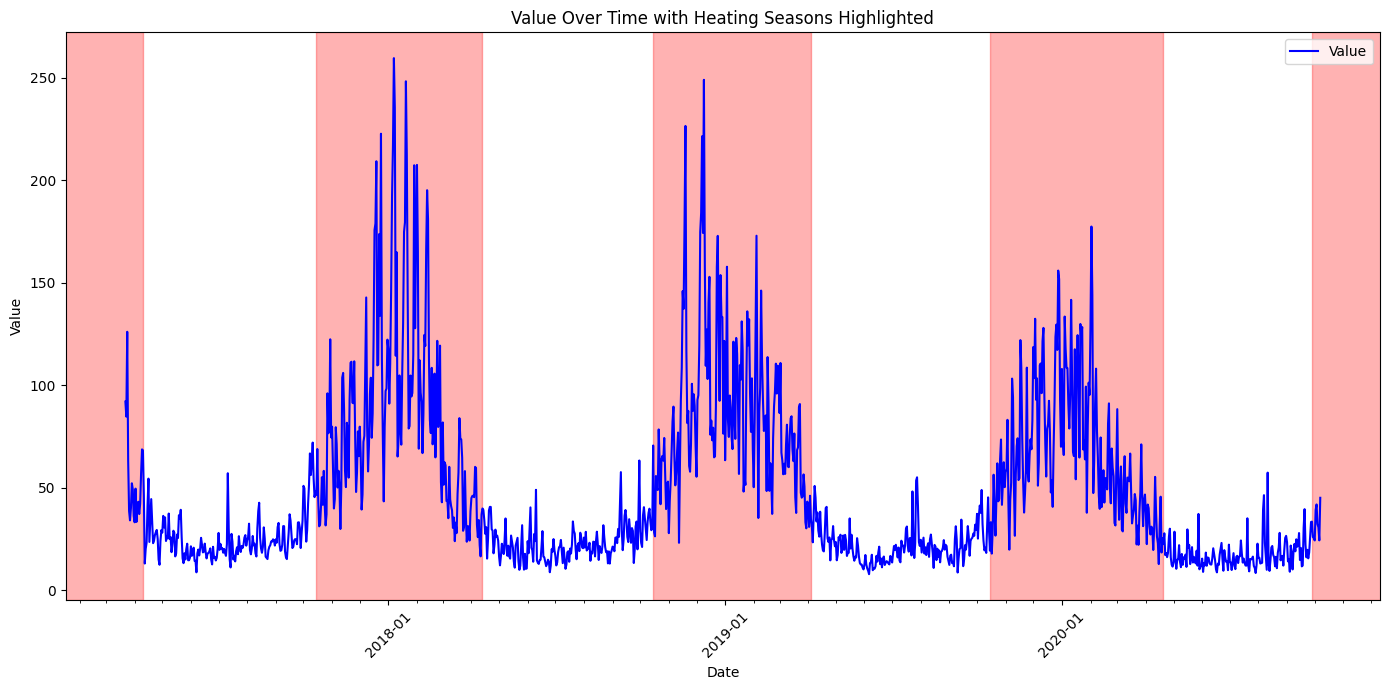

In [25]:
import matplotlib.dates as mdates
df['date_time'] = pd.to_datetime(df['date_time'])
heating_seasons = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in heating_season_dates]

# Plotting
fig, ax = plt.subplots(figsize=(14, 7))

# Plot the value over time
ax.plot(df['date_time'], df['value'], label='Value', color='blue')

# Highlight heating seasons
for start, end in heating_seasons:
    ax.axvspan(start, end, color='red', alpha=0.3)

# Formatting the x-axis to show dates clearly
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Adding labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Value Over Time with Heating Seasons Highlighted')

# Adding a legend
ax.legend()

# Rotating date labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

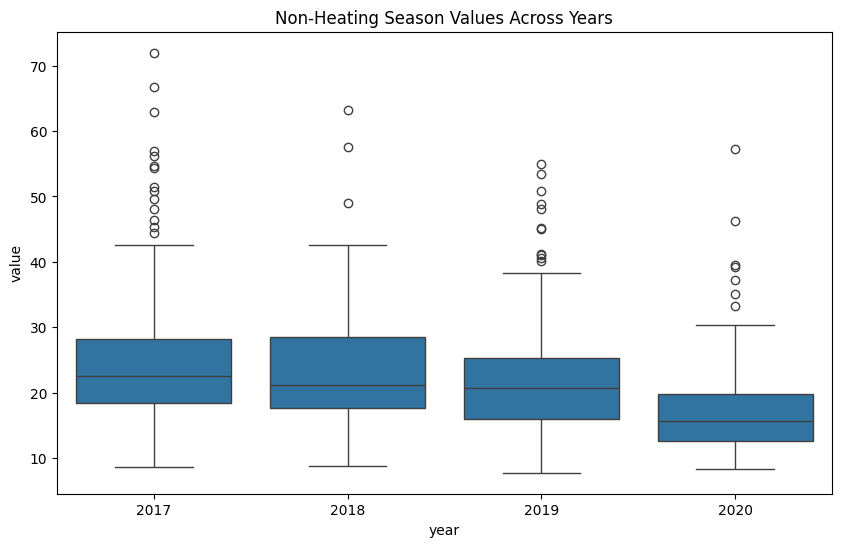

Descriptive Statistics:
       count       mean        std       min        25%        50%        75%  \
year                                                                           
2017  187.0  25.309279  10.679498  8.681383  18.459797  22.631332  28.258919   
2018  185.0  23.154032   8.797674  8.723604  17.607998  21.256689  28.443447   
2019  193.0  22.027954   8.881209  7.769390  15.943429  20.721307  25.344985   
2020  160.0  17.313292   7.207243  8.348889  12.657028  15.689547  19.820954   

            max  
year             
2017  71.980782  
2018  63.234108  
2019  55.027438  
2020  57.316500  

ANOVA Result:
F-statistic: 23.675585644304938 P-value: 1.2694632384014552e-14

ADF Test Result:
ADF Statistic: -4.618752607493249 P-value: 0.00011927059828014883


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import adfuller

# Assuming 'df' is your DataFrame with 'date_time' and 'value' columns
df['date_time'] = pd.to_datetime(df['date_time'])
df['year'] = df['date_time'].dt.year

# Define heating season dates
heating_season_dates = [
    ['2016-10-15', '2017-04-10'],
    ['2017-10-15', '2018-04-12'],
    ['2018-10-15', '2019-04-04'],
    ['2019-10-15', '2020-04-20'],
    ['2020-09-28', '2021-04-13'],
    # ['2021-10-02', '2022-04'],
]

# Function to check if a date is within any heating season
def is_heating_season(date):
    for start, end in heating_season_dates:
        if pd.to_datetime(start) <= date <= pd.to_datetime(end):
            return True
    return False

# Filter non-heating season data
df['is_heating'] = df['date_time'].apply(is_heating_season)
non_heating_df = df[~df['is_heating']]

# Descriptive statistics
descriptive_stats = non_heating_df.groupby('year')['value'].describe()

# Box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='year', y='value', data=non_heating_df)
plt.title('Non-Heating Season Values Across Years')
plt.show()

# ANOVA test
anova_result = stats.f_oneway(
    *[group['value'].values for name, group in non_heating_df.groupby('year')]
)

# Check for stationarity
adf_result = adfuller(non_heating_df['value'])

# Output results
print("Descriptive Statistics:\n", descriptive_stats)
print("\nANOVA Result:\nF-statistic:", anova_result.statistic, "P-value:", anova_result.pvalue)
print("\nADF Test Result:\nADF Statistic:", adf_result[0], "P-value:", adf_result[1])


2020 has a very different distribution due to COVID-19. in KZ it started in march 2020 and ended in may 2023 (more like 2022) 

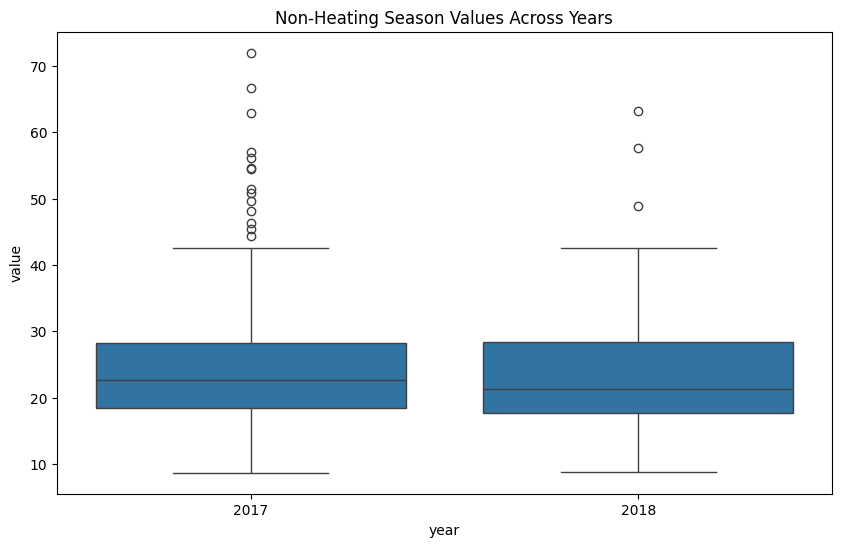

Descriptive Statistics:
       count       mean        std       min        25%        50%        75%  \
year                                                                           
2017  187.0  25.309279  10.679498  8.681383  18.459797  22.631332  28.258919   
2018  185.0  23.154032   8.797674  8.723604  17.607998  21.256689  28.443447   

            max  
year             
2017  71.980782  
2018  63.234108  

ANOVA Result:
F-statistic: 4.508042276676759 P-value: 0.03439912114838339

ADF Test Result:
ADF Statistic: -3.9783282645034714 P-value: 0.00152834034328079


In [23]:
df_filtered = df[df['date_time'].dt.year < 2019]

non_heating_df = df_filtered[~df_filtered['is_heating']]

# Descriptive statistics
descriptive_stats = non_heating_df.groupby('year')['value'].describe()

# Box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='year', y='value', data=non_heating_df)
plt.title('Non-Heating Season Values Across Years')
plt.show()

# ANOVA test
anova_result = stats.f_oneway(
    *[group['value'].values for name, group in non_heating_df.groupby('year')]
)

# Check for stationarity
adf_result = adfuller(non_heating_df['value'])

# Output results
print("Descriptive Statistics:\n", descriptive_stats)
print("\nANOVA Result:\nF-statistic:", anova_result.statistic, "P-value:", anova_result.pvalue)
print("\nADF Test Result:\nADF Statistic:", adf_result[0], "P-value:", adf_result[1])


Если предположить, что в течении года выброс от машин стабильный и автономное отопление работает с сент по май, то можно взять среднее за май-сент и отнять от уровня в сезон отопления. Возьмем среднее за весь обозравемый сезон. 

In [31]:
results = []

# Iterate over each heating season
for start, end in heating_seasons:
    # Determine the year for the non-heating period
    non_heating_year = start.year if start.month > 4 else start.year - 1
    
    # Define the non-heating period (May 1st to August 31st)
    non_heating_start = pd.Timestamp(f'{non_heating_year}-05-01')
    non_heating_end = pd.Timestamp(f'{non_heating_year}-08-31')
    
    # Filter data for the non-heating period
    non_heating_data = df[(df['date_time'] >= non_heating_start) & (df['date_time'] <= non_heating_end)]
    
    # Filter data for the heating season
    heating_and_car_data = df[(df['date_time'] >= start) & (df['date_time'] <= end)]
    
    # Calculate means
    mean_car_pollution = non_heating_data['value'].mean()
    mean_heating_and_car_pollution = heating_and_car_data['value'].mean()
    
    # Calculate the difference
    difference = mean_heating_and_car_pollution - mean_car_pollution
    
    # Store the results
    results.append({
        'Non-Heating Year': non_heating_year,
        # 'Heating Season Start': start,
        # 'Heating Season End': end,
        'Mean Car Pollution (Non-Heating)': mean_car_pollution,
        'Mean Pollution (Heating Season)': mean_heating_and_car_pollution,
        'Difference': difference, 
        'car/full': mean_car_pollution/mean_heating_and_car_pollution,
        'heating/full': difference/mean_heating_and_car_pollution,
    })

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

In [32]:
results_df

,Non-Heating Year,Mean Car Pollution (Non-Heating),Mean Pollution (Heating Season),Difference,car/full,heating/full
0,2016,NaN,54.515634,NaN,NaN,NaN
1,2017,21.982444,86.563611,64.581168,0.253946,0.746054
2,2018,19.666875,86.553831,66.886957,0.227221,0.772779
3,2019,19.465213,66.579931,47.114718,0.292359,0.707641
4,2020,16.512832,32.193582,15.680750,0.512923,0.487077


Если предположить, что с 1 января по 10  

In [36]:
import matplotlib.dates as mdates
import plotly.graph_objects as go
df['date_time'] = pd.to_datetime(df['date_time'])
post_new_year_dates = [
    ['2017-01-01', '2017-01-10'],
    ['2018-01-01', '2018-01-10'],
    ['2019-01-01', '2019-01-10'],
    ['2020-01-01', '2020-01-10'],
                       ]
highlight_periods = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in post_new_year_dates]

# Create the figure
fig = go.Figure()

# Add the time series line
fig.add_trace(go.Scatter(x=df['date_time'], y=df['value'], mode='lines', name='Value'))

# Add shaded regions for the highlight periods
for start, end in highlight_periods:
    fig.add_shape(
        type="rect",
        x0=start, x1=end,
        y0=min(df['value']), y1=max(df['value']),
        fillcolor="red", opacity=0.3, line_width=0,
    )

# Update layout
fig.update_layout(
    title="Value Over Time with Highlighted Periods",
    xaxis_title="Date",
    yaxis_title="Value",
    xaxis=dict(
        tickformat="%Y-%m-%d",
        tickangle=45,
        rangeslider=dict(visible=True),
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        )
    )
)

# Show the plot
fig.show()

supposedly, it doesn't work